In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from IPython.core.display import display, HTML
from warnings import filterwarnings
from wordcloud import WordCloud
filterwarnings('ignore')

In [4]:
df = pd.read_csv("content/mobile-device-usage-and-user-behavior-dataset/user_behavior_dataset.csv")

In [5]:
df.sample(5)

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
279,280,Samsung Galaxy S21,Android,411,7.8,2029,75,1136,33,Female,4
86,87,Samsung Galaxy S21,Android,151,2.4,1003,25,392,39,Male,2
642,643,Google Pixel 5,Android,502,8.2,2597,90,1553,27,Male,5
511,512,Samsung Galaxy S21,Android,567,10.8,2911,89,1682,39,Male,5
157,158,Xiaomi Mi 11,Android,339,7.8,2102,71,1062,51,Male,4


In [6]:
num_records = len(df)
num_records

700

In [7]:
num_columns = len(df.columns)
num_columns

11

In [8]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['Duplicate'] = df.duplicated().sum()
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['avg'] = desc['mean'].values
    summ['std dev'] = desc['std'].values
    summ['top value'] = desc['top'].values
    summ['Freq'] = desc['freq'].values

    return summ

summary(df).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev,top value,Freq
User ID,int64,0,0,700,1.000000,700.000000,350.500000,202.216880,nan,nan
Device Model,object,0,0,5,nan,nan,nan,nan,Xiaomi Mi 11,146
Operating System,object,0,0,2,nan,nan,nan,nan,Android,554
App Usage Time (min/day),int64,0,0,387,30.000000,598.000000,271.128571,177.199484,nan,nan
Screen On Time (hours/day),float64,0,0,108,1.000000,12.000000,5.272714,3.068584,nan,nan
Battery Drain (mAh/day),int64,0,0,628,302.000000,2993.000000,1525.158571,819.136414,nan,nan
Number of Apps Installed,int64,0,0,86,10.000000,99.000000,50.681429,26.943324,nan,nan
Data Usage (MB/day),int64,0,0,585,102.000000,2497.000000,929.742857,640.451729,nan,nan
Age,int64,0,0,42,18.000000,59.000000,38.482857,12.012916,nan,nan
Gender,object,0,0,2,nan,nan,nan,nan,Male,364


In [9]:
unique_counts = df.nunique()
html_output = "<br>".join([f"<b style='color:green;'>{col}  :</b> <b style='color:black;'>{count}</b>" for col, count in unique_counts.items()])
display(HTML(html_output))


In [10]:
def univariateAnalysis_category(cols):
    print("Distribution of", cols)
    print("_" * 60)
    colors = [
        '#FFD700', '#FF6347', '#40E0D0', '#FF69B4', '#7FFFD4',  
        '#FFA500', '#00FA9A', '#FF4500', '#4682B4', '#DA70D6',  
        '#FFB6C1', '#FF1493', '#FF8C00', '#98FB98', '#9370DB', 
        '#32CD32', '#00CED1', '#1E90FF', '#FFFF00', '#7CFC00'  
    ]
    value_counts = cat_columns[cols].value_counts()

    fig = px.bar(
        value_counts,
        x=value_counts.index,
        y=value_counts.values,
        title=f'Distribution of {cols}',
        labels={'x': 'Categories', 'y': 'Count'},
        color_discrete_sequence=[colors]
    )
    fig.update_layout(
        plot_bgcolor='#000000',
        paper_bgcolor='#000000',
        font=dict(color='white', size=12), 
        title_font=dict(size=30),
        legend_font=dict(color='white', size=12),
        width=500,  # Adjusted width
        height=400  # Adjusted height
    )
    fig.show()

    percentage = (value_counts / value_counts.sum()) * 100
    
    fig = px.pie(
        values=percentage,
        names=value_counts.index,
        labels={'names': 'Categories', 'values': 'Percentage'},
        hole=0.5,
        color_discrete_sequence=colors
    )
    fig.add_annotation(
        x=0.5, y=0.5,
        text=f'{cols}',
        font=dict(size=18, color='white'),
        showarrow=False
    )
    fig.update_layout(
        plot_bgcolor='#000000',
        paper_bgcolor='#000000',
        font=dict(color='white', size=12),
        title_font=dict(size=30),
        legend=dict(x=0.9, y=0.5),
        legend_font=dict(color='white', size=12),
        width=500,  # Adjusted width
        height=400  # Adjusted height
    )
    fig.show()
    print("       ")
    
cat_columns = df[['Device Model', 'Operating System', 'Gender', 'User Behavior Class']]
for x in cat_columns:
    univariateAnalysis_category(x)


Distribution of Device Model
____________________________________________________________


       
Distribution of Operating System
____________________________________________________________


       
Distribution of Gender
____________________________________________________________


       
Distribution of User Behavior Class
____________________________________________________________


In [11]:
colors = [
    '#FFD700',
    '#FFA500', '#00FA9A',
    '#FFB6C1', '#FF1493',
    '#32CD32', '#00CED1', '#1E90FF', '#FFFF00', '#7CFC00'
]


def create_histplot(df, x, title, nbins=80, color_index=0):
    print("\n\n")
    
    fig = px.histogram(df, x, nbins=nbins)
    fig.update_traces(marker_color=colors[color_index])
    fig.update_layout(
        title=f'Distribution of {x}',
        width=560, height=370,
        plot_bgcolor='black',
        paper_bgcolor='black',
        font_color='white',
        font=dict(color='white', size=15), 
        title_font=dict(size=25)
    )
    fig.show()

create_histplot(df, 'App Usage Time (min/day)', 'App Usage Time (min/day)', nbins=50, color_index=0)
create_histplot(df, 'Battery Drain (mAh/day)', 'Battery Drain (mAh/day)', nbins=50, color_index=1)
create_histplot(df, 'Data Usage (MB/day)', 'Data Usage (MB/day)', nbins=50, color_index=2)
create_histplot(df, 'Screen On Time (hours/day)', 'Screen On Time (hours/day)', nbins=50, color_index=3)
create_histplot(df, 'Number of Apps Installed', 'Number of Apps Installed', nbins=50, color_index=4)

In [12]:
import plotly.express as px
from IPython.display import display, HTML

numeric_df = df.select_dtypes(include=['number'])
numeric_columns = numeric_df.columns.tolist()
numeric_columns = [col for col in numeric_columns if col != 'User ID']

def groupby(data, x):
    result = data.groupby(x).size().rename('count').reset_index()
    return result

def create_scatter_plot(data, x, y, title, xaxis_title, yaxis_title, color, width=550, height=350):  
    fig = px.scatter(data, x=x, y=y, size=y, color_discrete_sequence=[color])
    fig.update_traces(marker=dict(opacity=1))
   
    fig.update_layout(
        title=f'Distribution of {x}',
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        plot_bgcolor='black',
        width=width,
        paper_bgcolor='black',
        font=dict(color='white', size=15),
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False),
        height=height,
        title_font=dict(size=25)
    )
    fig.show()

    
color = [
    '#FFD700',
    '#FFA500', '#00FA9A',
    '#FFB6C1', '#FF1493',
    '#32CD32', '#00CED1', '#1E90FF', '#FFFF00', '#7CFC00'
]



features = ['Screen On Time (hours/day)','Number of Apps Installed','Age', 'User Behavior Class']

for i, feature in enumerate(features):
   
    grouped_data = groupby(df, feature)
    create_scatter_plot(grouped_data, feature, 'count', f'{feature} Distribution', feature, 'Count', color[i])
    print("\n\n\n")


In [13]:
def groupby(data, x):
    result = data.groupby(x).size().rename('count').reset_index()
    return result

def plot_scatter(df, x_col, y_col, color=None):
    print("\n\n")
    display(HTML(f"<h2 style='text-align:left; font-size:27px; font-weight:bold;'>{x_col} vs {y_col}</h2>"))
    
    colors = [
        '#FFD700', '#FF6347', '#40E0D0', '#FF69B4', '#7FFFD4',  
        '#FFA500', '#00FA9A', '#FF4500', '#4682B4', '#DA70D6',  
        '#FFB6C1', '#FF1493', '#FF8C00', '#98FB98', '#9370DB', 
        '#32CD32', '#00CED1', '#1E90FF', '#FFFF00', '#7CFC00'  
    ]
    
    fig = px.scatter(
        df,
        x=x_col,
        y=y_col,
        color=df[color].astype(str) if color is not None else None,
        color_discrete_sequence=colors  
    )
    
    fig.update_layout(
        xaxis_title=x_col,
        yaxis_title=y_col,
        plot_bgcolor='#000000',
        paper_bgcolor='#000000',
        font=dict(color='white', size=11),
        xaxis=dict(showgrid=False, zeroline=True, zerolinecolor='white', showline=False),  
        yaxis=dict(showgrid=True, zeroline=True, zerolinecolor='white', showline=False), 
        legend_title_text=color,
        legend_font=dict(color='white', size=12),
        width=500,  
        height=350,
        
        
    )
    
   
    fig.show()

plot_scatter(df, 'App Usage Time (min/day)', 'Screen On Time (hours/day)',  'User Behavior Class')
plot_scatter(df, 'Battery Drain (mAh/day)', 'Data Usage (MB/day)',  'User Behavior Class')
plot_scatter(df, 'User Behavior Class', 'Number of Apps Installed',  'User Behavior Class')
plot_scatter(df, 'Device Model', 'Screen On Time (hours/day)', 'Operating System')
plot_scatter(df, 'Gender', 'Screen On Time (hours/day)', 'Gender')
plot_scatter(df, 'Gender', 'Number of Apps Installed', 'Gender')
plot_scatter(df, 'User Behavior Class', 'Age', 'User Behavior Class')
plot_scatter(df, 'Data Usage (MB/day)', 'Age', 'User Behavior Class')


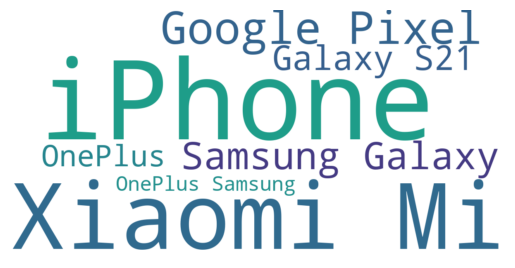

In [14]:
wordcloud = WordCloud(width = 1200, height = 600,background_color = 'white').generate(' '.join(df['Device Model']))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [15]:
import plotly.express as px

def hist(df,x ,color):
    print("\n\n")
    colors = [
        'yellow', 'red']
    fig = px.histogram(
        df,
        x=x,
        color = color,
        barmode='group',
        color_discrete_sequence=colors
    )
    
    fig.update_layout(
        xaxis_title=x,
        yaxis_title='Count',
        plot_bgcolor='#000000',
        paper_bgcolor='#000000',
        font=dict(color='white', size=15),
        xaxis=dict(showgrid=False, zeroline=True, zerolinecolor='white', showline=False),  
        yaxis=dict(showgrid=True, zeroline=True, zerolinecolor='white', showline=False), 
        legend_title_text=color,
        legend_font=dict(color='white', size=12),
        width=520,  
        height=350,
        title = f"{x} vs {color}",
        title_font=dict(size=21,weight="bold")
        
    )
    fig.show()
    
hist(df,'User Behavior Class' ,'Operating System')
hist(df,'User Behavior Class' ,'Gender')

In [16]:
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
fig = go.Figure(data=go.Heatmap(z=correlation_matrix, x=correlation_matrix.columns, y=correlation_matrix.columns))
fig.update_layout(title='Correlation Heatmap')
fig.show()